In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
rng = np.random.default_rng(12345)

In [2]:
class Room(object):
    def __init__(self, h, w, c):
        self.update_hwc(h,w,c)
    def update_hwc(self, h, w, c):
        self.h = h
        self.w = w
        self.c = c
        
    @classmethod
    def from_vert(cls, vert):
        min_x, max_x = np.min(vert[:,0]),np.max(vert[:,0])
        min_y, max_y = np.min(vert[:,1]),np.max(vert[:,1])
        h = max_y - min_y
        w = max_x - min_x
        c = np.array([max_x+min_x,max_y+min_y])/2
        return cls(h,w,c)
    
    def get_vert(self):
        return self.c + np.array([[self.w, self.h],[-self.w,self.h],[-self.w,-self.h],[self.w,-self.h]])/2
    
    def get_area(self):
        return self.h*self.w
    
    def add_door(self, door):
        self.door = door
        

In [3]:
room_h = 15
room_w = 12

main_room = np.array([[room_w,room_h],[-room_w,room_h],[-room_w,-room_h],[room_w,-room_h]])/2
r = Room.from_vert(main_room)

print(r.h, r.w, r.c, r.get_vert()[:,0])

15.0 12.0 [0. 0.] [ 6. -6. -6.  6.]


In [4]:
def split_room(room, axis, corridor_w):
    min_, max_ = np.min(room[:,axis]),np.max(room[:,axis])
    split = rng.random()*(max_-min_)+min_
    room1 = room.copy()
    result = []
    room1[room1[:,axis]==min_,axis] = split+corridor_w/2
    room2 = room.copy()
    room2[room2[:,axis]==max_,axis] = split-corridor_w/2
    return [room1, room2]

def split_room(room, axis, corridor_w):
    min_, max_ = np.min(room.get_vert()[:,axis]),np.max(room.get_vert()[:,axis])
    split = rng.random()*(max_-min_)+min_
    #split = rng.normal(room.c[axis], 1.5)
    print(split)
    room1 = room.get_vert().copy()
    result = []
    room1[room1[:,axis]==min_,axis] = split+corridor_w/2
    room1 = Room.from_vert(room1)
    room2 = room.get_vert().copy()
    room2[room2[:,axis]==max_,axis] = split-corridor_w/2
    room2 = Room.from_vert(room2)
    return [room1, room2]

In [5]:
room_h = 15
room_w = 12

main_room = np.array([[room_w,room_h],[-room_w,room_h],[-room_w,-room_h],[room_w,-room_h]])/2
main_room = Room.from_vert(main_room)

axis = 1
corridor_w = 1.5


rooms = []
new_rooms = []

rooms.append(main_room)
for room in rooms:
    split = split_room(room, axis, corridor_w)
    new_rooms=[r for r in split if r.get_area() > 1 and min(r.h,r.w) > 1]
rooms = new_rooms


while len(rooms) < 5:
    new_rooms = []
    axis = 1 - axis
    corridor_w *= 0.9
    for room in rooms:
        split = split_room(room, axis, corridor_w)
        new_rooms+=[r for r in split if r.get_area() > 1 and min(r.h,r.w) > 1]
    r_idx = np.arange(len(new_rooms))
    rng.shuffle(r_idx)
    rooms = [new_rooms[i] for i in r_idx]

#new_rooms = []
#axis = 1 - axis
#for room in rooms:
 #   split = split_room(room, axis, corridor_w)
 #   new_rooms+=[r for r in split if r.get_area() > 1 and min(r.h,r.w) > 1]
#rooms = new_rooms

-4.089959662992455
-2.1988999234829656
3.56838548799281
-6.614701527157498
3.1456830919079746
-7.003279533995869
3.9526887171604166


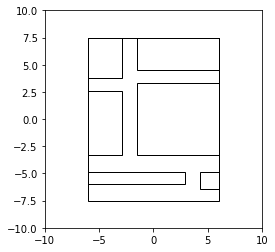

In [6]:
plot_rooms = [main_room]+rooms
fig, ax = plt.subplots()
for r in plot_rooms:
    polygon = Polygon(r.get_vert(), fill=False)
    ax.add_patch(polygon)
plt.xlim([-10,10])
plt.ylim([-10,10])
ax.set_aspect('equal', 'box')
plt.show()

In [7]:
polygon.get_xy()

array([[ 2.89338549, -4.83995966],
       [-6.        , -4.83995966],
       [-6.        , -6.00720153],
       [ 2.89338549, -6.00720153],
       [ 2.89338549, -4.83995966]])

In [8]:
min(1,2)

1